In [140]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

Time series analysis and forecasting of 'Office Supplies' sales

In [105]:
df = pd.read_excel("Superstore.xls")
office_supplies = df.loc[df['Category'] == 'Office Supplies']

Timeperiod of data - 2014 to 2017

In [106]:
office_supplies['Order Date'].min()

Timestamp('2014-01-03 00:00:00')

In [107]:
office_supplies['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

### Data preparation 
Below steps includes removing unwanted columns, check missing values, aggregate sales by date etc.

In [108]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name',
        'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID',
        'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
office_supplies.drop(cols, axis=1, inplace=True)
office_supplies = office_supplies.sort_values('Order Date')

In [109]:
office_supplies.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [110]:
office_supplies = office_supplies.groupby('Order Date')['Sales'].sum().reset_index()

In [111]:
office_supplies.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


### Indexing 

In [112]:
office_supplies = office_supplies.set_index('Order Date')
office_supplies.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06',
               '2014-01-07', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-16', '2014-01-18',
               ...
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1148, freq=None)

Since the current datetime data seems tricky to work with, therefore we will use the averages daily sales value for the month instead, and use start of each month as the timestamp.

In [113]:
y = office_supplies['Sales'].resample('MS').mean()

In [114]:
y['2017':]

Order Date
2017-01-01     967.013136
2017-02-01     389.882737
2017-03-01     538.899481
2017-04-01     558.229296
2017-05-01     508.776444
2017-06-01     650.463038
2017-07-01     393.902615
2017-08-01    1156.148154
2017-09-01    1139.137250
2017-10-01     886.045846
2017-11-01    1124.012036
2017-12-01    1049.549724
Freq: MS, Name: Sales, dtype: float64

### Office Supply sales time series data

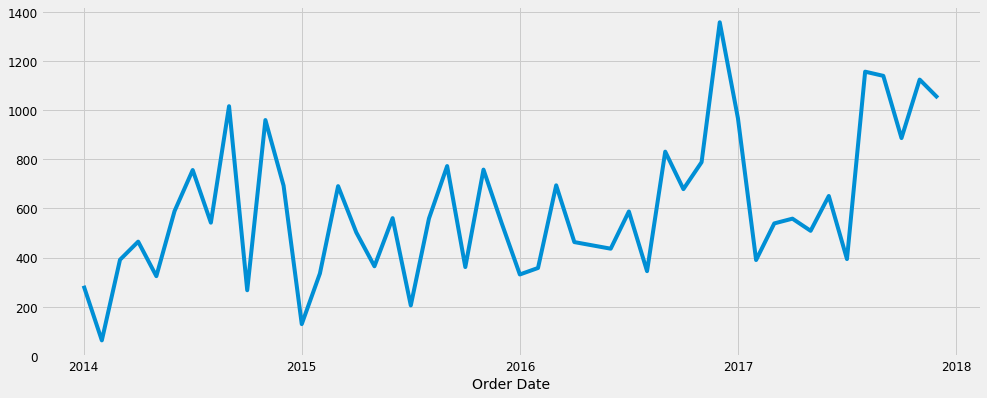

In [115]:
y.plot(figsize=(15, 6))
plt.show()

The above time-series shows some seasonal pattern, such as sales are always low at the beginning of the year and high at the end of the year. 

We can visualize our data using time-series decomposition as well; which allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

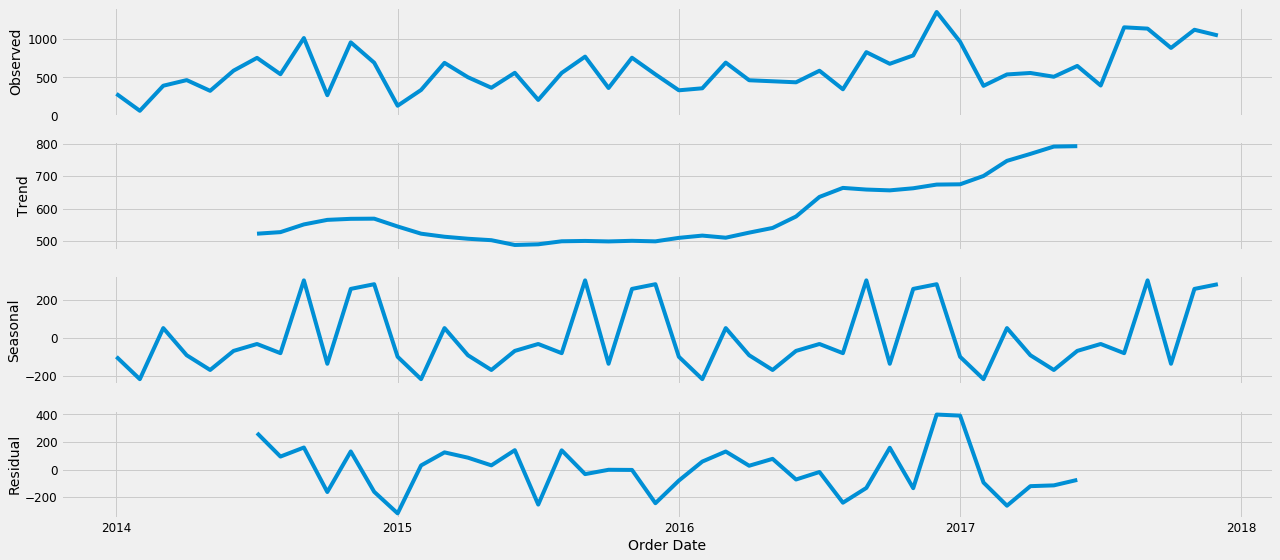

In [116]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Time series forecasting using ARIMA

Parameter Selection for the ARIMA Model

In [117]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [118]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:747.1990404010083
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1513.1922195726854
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:500.7335398750499
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:516.0876543936832
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1246.6176640399606
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:347.44488563489716
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:702.6891395292483
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2741.5845052053155
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:487.76014158147757
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:517.4952646586937
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2819.2138797372695
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:345.69220944600795
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:666.4572045007284
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1392.6136426438977
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:503.0840747609876
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:500.0109385290892
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1589.544411351558
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:335.7148959418817
AR

In [120]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2479      0.328      0.755      0.450      -0.395       0.891
ma.L1         -0.9389      0.462     -2.030      0.042      -1.845      -0.032
ar.S.L12      -0.6135      0.348     -1.762      0.078      -1.296       0.069
sigma2      7.421e+04   2.68e+04      2.768      0.006    2.17e+04    1.27e+05


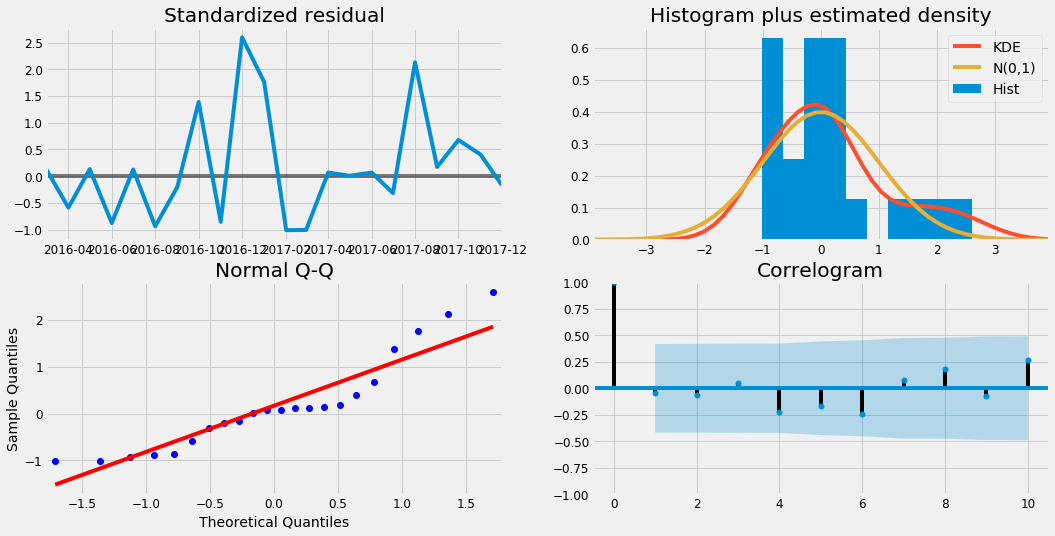

In [121]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Validation

To determine the accuracy of the forecaste, below is the method to compare predicted sales to real sales of the time series, and the start date considered is 2017-07-01 to the end of the data

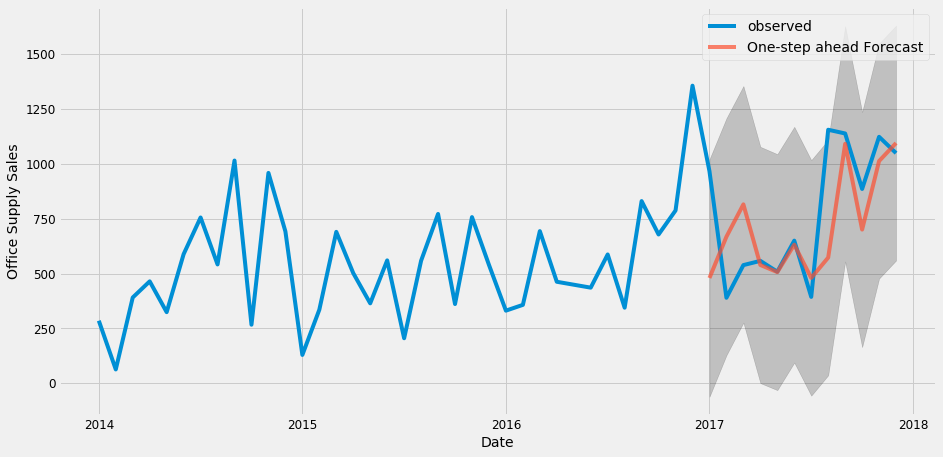

In [122]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Office Supply Sales')
plt.legend()

plt.show()

The line plot shows the observed values compared to the rolling forecast predictions. Overall, the forecasts align with the true values quite well, showing an upward trend starting from the beginning of the year.

In [123]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 65844.6


In [124]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 256.6


MEAN SQAURED ERROR (MSE) of an estimator measures the average of the squares of the errors — i.e the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

ROOT MEAN SQAURE ERROR (RMSE) tells that the model is able to forecast the average daily office supplies sales in the test set within 256.6 of the real sales. The office supplies daily sales ranges from around 300 to over 1200.

### Visualizing forecasts

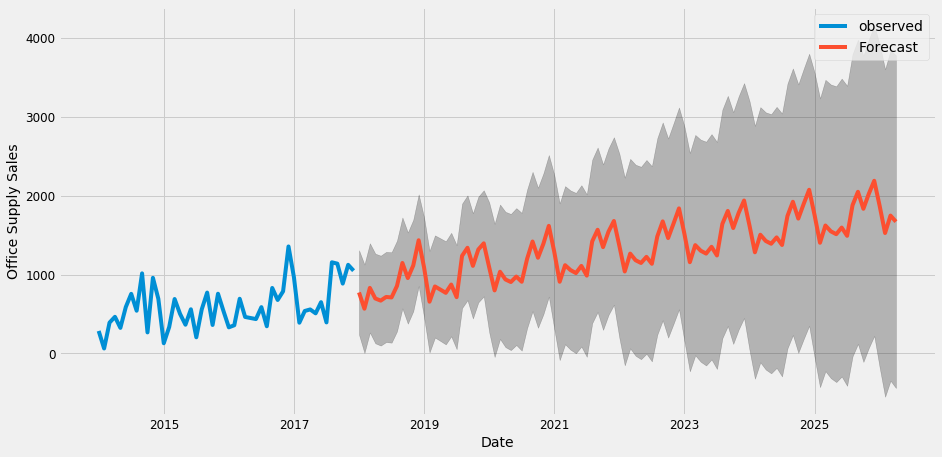

In [125]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supply Sales')

plt.legend()
plt.show()

The model shows to capture office supplies sales seasonality. As the model predicts the future values, it is natural to be less confident in the values. This is reflected by the confidence intervals generated by the model, which grows larger for the future values.

### Office Supplies vs Technology

In [126]:
office_supplies = df.loc[df['Category'] == 'Office Supplies']
technology = df.loc[df['Category'] == 'Technology']

In [127]:
office_supplies.shape, technology.shape

((6026, 21), (1847, 21))

In [128]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
office_supplies.drop(cols, axis=1, inplace=True)
technology.drop(cols, axis=1, inplace=True)

office_supplies = office_supplies.sort_values('Order Date')
technology = technology.sort_values('Order Date')

office_supplies = office_supplies.groupby('Order Date')['Sales'].sum().reset_index()
technology = technology.groupby('Order Date')['Sales'].sum().reset_index()

In [129]:
office_supplies.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


In [130]:
technology.head()

,Order Date,Sales
0,2014-01-06,1147.94
1,2014-01-09,31.20
2,2014-01-13,646.74
3,2014-01-15,149.95
4,2014-01-16,124.20


### Data exploration

Below is a method to compare two categories' sales in the same time period. This means combining two data frames into one and ploting the two categories' time series into one plot.

In [141]:
office_supplies = office_supplies.set_index('Order Date')
technology = technology.set_index('Order Date')

y_office_supplies = office_supplies['Sales'].resample('MS').mean()
y_technology = technology['Sales'].resample('MS').mean()

office_supplies = pd.DataFrame({'Order Date':y_office_supplies.index, 'Sales':y_office_supplies.values})
technology = pd.DataFrame({'Order Date': y_technology.index, 'Sales': y_technology.values})

store = office_supplies.merge(technology, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'office_supply_sales', 'Sales_y': 'technology_sales'}, inplace=True)
store.head()

,Order Date,office_supply_sales,technology_sales
0,2014-01-01,285.357647,449.041429
1,2014-02-01,63.042588,229.787143
2,2014-03-01,391.176318,2031.948375
3,2014-04-01,464.794750,613.028933
4,2014-05-01,324.346545,564.698588


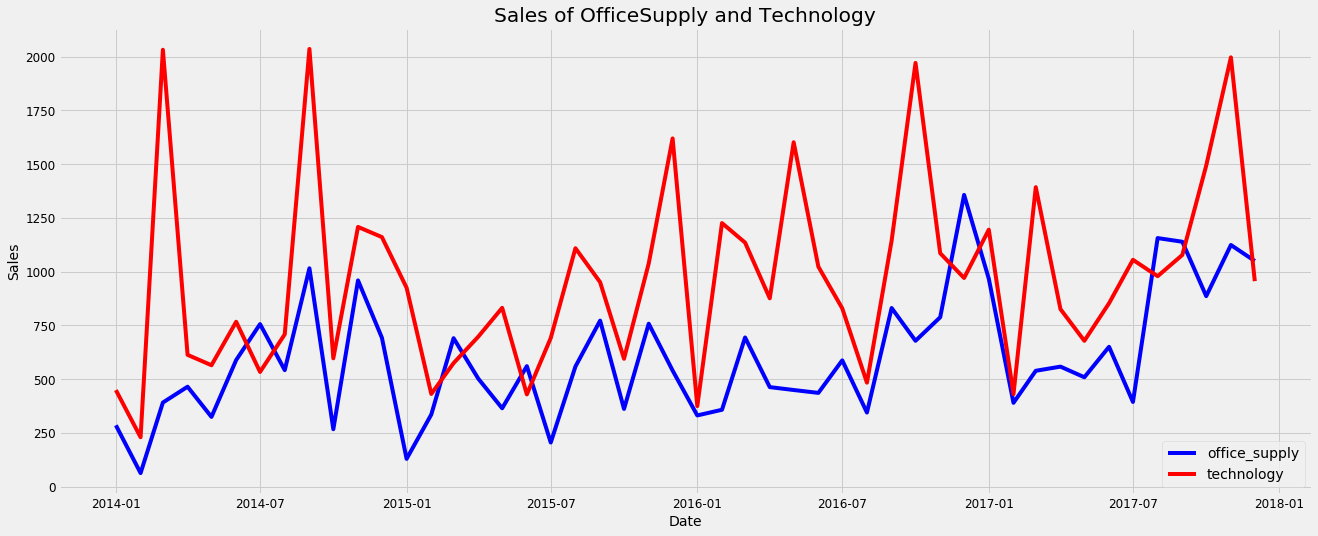

In [143]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['office_supply_sales'], 'b-', label = 'office_supply')
plt.plot(store['Order Date'], store['technology_sales'], 'r-', label = 'technology')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of OfficeSupply and Technology')
plt.legend();

In [142]:
first_date = store.ix[np.min(list(np.where(store['office_supply_sales'] > store['technology_sales'])[0])), 'Order Date']

print("Office Supply first time produced higher sales than Technology is {}.".format(first_date.date()))

Office Supply first time produced higher sales than Technology is 2014-07-01.


We observe that sales of office supplies and technology shares a similar seasonal pattern. Below are few findings from this project:

- Early of the year is the off season for both of the two categories (Office Supplies and Technology) 
- The summer time is quiet for office supplies. 
- Average daily sales for Technology are higher than those of Office Supplies in most of the months.
- Occasionally, Office Supplies passed Technology on average daily sales. 

The first time when the Office Supplies' sales surpassed those of Technology was on "JULY 2014".